# Visualizing 2-D soil moisture model

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio

def calculate_water_table_depth(psi, zsoil, layer_depth):
    if psi[-1] < 0.0:
        return zsoil[-1]

    if all(psi >= 0.0):
        return 0.0

    for kz in np.arange(len(zsoil) - 1, 0, -1):
        if psi[kz] >= 0.0 and psi[kz - 1] < 0.0:
            return zsoil[kz - 1] - 0.5 * layer_depth + layer_depth * (psi[kz - 1] / (psi[kz - 1] - psi[kz]))

In [31]:
with open('input/test/domain.txt') as f:
    lines = f.readlines()

number_of_columns = int(lines[0].split()[0])
number_of_layers = int(lines[1].split()[0])
layer_depth = float(lines[2].split()[0])

with open('input/test/topography.txt') as f:
    lines = f.readlines()

elevations = np.array([float(x) for x in lines[0].split()[0:number_of_columns]]) #/ 10.0
widths = np.array([float(x) for x in lines[1].split()[0:number_of_columns]])

#zsoil = np.arange(layer_depth, (number_of_layers + 1) * layer_depth, layer_depth)
y = []
for k in range(number_of_layers):
    if k == 0:
        y.append(elevations)
    else:
        y.append(y[-1] - layer_depth)
y = np.array(y)

x = []
for k in range(number_of_layers):
    x.append(np.cumsum(widths) - widths[0])

x = np.array(x)

In [32]:
smc_df = pd.read_csv(
    'smc.txt',
    index_col=0,
)

wp_df = pd.read_csv(
    'wp.txt',
    index_col=0,
)

channel_df = pd.read_csv(
    'channel.txt',
    index_col=0,
)

In [33]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

frames = []

inset_location = [0.1, 0.1, 0.25, 0.25],
#for t in range(len(smc_df)):
for t in range(0, len(smc_df) + 1, 12):
    fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
    c = ax.pcolor(
        x, y, smc_df.iloc[t].values.reshape((number_of_columns, number_of_layers)).T,
        vmin=0.25,
        vmax=0.464,
        cmap='coolwarm_r'
    )
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    fig.colorbar(c, ax=ax, label='Soil moisture content (m$^3$ m$^{-3}$)')
    ax.set_xlabel('x (m)')
    ax.set_title(f'Step: {t}')


    inset_ax = ax.inset_axes(
        inset_location[0],
    )
    inset_ax.plot(
        channel_df.values[:, 1],
    )

    y_max = inset_ax.get_ylim()[1]

    inset_ax.plot([t, t], [0, y_max], '--', color='tab:red')

    inset_ax.set_xticklabels([])
    inset_ax.set_ylabel('Discharge\n(mm day$^{-1}$)')
    inset_ax.set_ylim([0, y_max])

    fig.tight_layout()
    fname = f'tmp/smc_{t:04d}.png'
    fig.savefig(fname, dpi=300)
    plt.close()

    frames.append(imageio.v2.imread(fname))

imageio.mimsave(f'smc.gif', frames, duration=30 / len(frames) * 1000)
!rm tmp/smc_*.png

## Check one column

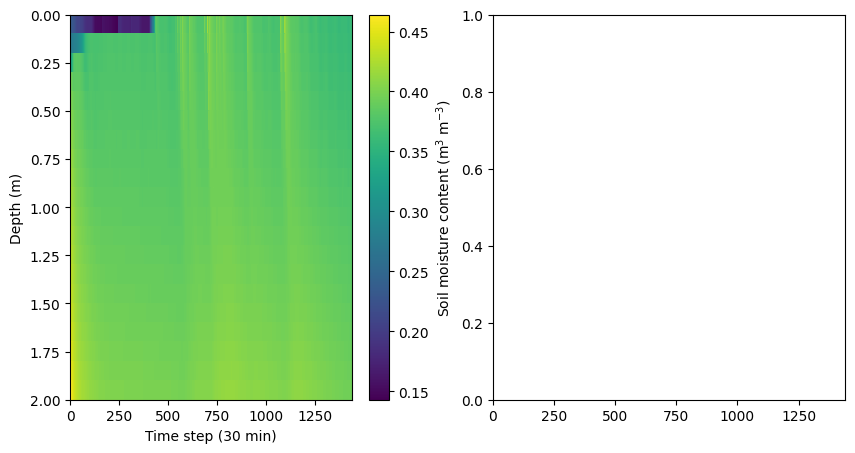

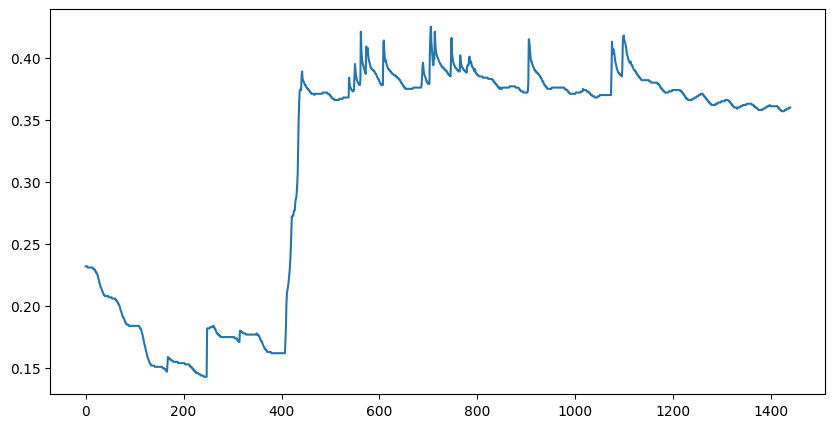

In [28]:
import matplotlib.pyplot as plt

y, x = np.mgrid[0:(number_of_layers + 1) * layer_depth:layer_depth, 0:1440 + 1:1]

df = pd.read_csv(
    'smc.txt',
    usecols=list(range(21)),
    header=None,
    index_col=0,
)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
c = axs[0].pcolor(x, y, df.values.T)
axs[0].set_ylabel('Depth (m)')
axs[0].set_ylim(0, 2.0)
axs[0].invert_yaxis()
fig.colorbar(c, ax=axs[0],label='Soil moisture content (m$^3$ m$^{-3}$)')
axs[0].set_xlabel('Time step (30 min)')

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.values[:, 0])
